In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle


# **Data Loading and Understanding**

In [ ]:
data = pd.read_csv('/content/sample_data/train.csv')

In [ ]:
pd.set_option('display.max_columns',None) # display all cols of a dataframe

In [ ]:
data.shape

(800, 22)

In [ ]:
data.tail()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
795,796,0,1,0,0,0,0,0,0,1,1,16.597187,m,Hispanic,no,no,New Zealand,no,12.999501,18 and more,Self,0
796,797,0,1,1,0,0,1,0,1,1,1,20.703001,m,White-European,no,no,Cyprus,no,13.561518,18 and more,Self,0
797,798,0,0,0,0,0,0,0,0,0,0,5.711481,m,South Asian,yes,no,New Zealand,no,2.653177,18 and more,Self,0
798,799,0,0,0,0,0,0,0,0,0,0,16.414305,f,?,no,no,Canada,no,9.069342,18 and more,Self,0
799,800,0,1,0,0,0,0,0,0,0,0,46.966113,f,?,no,no,United Arab Emirates,yes,2.243304,18 and more,Self,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [ ]:
# convert age column datatype to integer
data['age'] = data['age'].astype(int)

In [ ]:
for col in data.columns:
  numerial_cols = ["ID","age","result"]
  if col not in numerial_cols:
    print(col, data[col].unique())
    print('-'*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
austim

In [ ]:
# dropping unhelpful columns
data = data.drop(columns=['ID','age_desc', 'ethnicity', 'contry_of_res', 'used_app_before'])

In [ ]:
data.shape

(800, 17)

In [ ]:
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,no,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,no,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,no,yes,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,no,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,no,no,-4.777286,Self,0


In [ ]:
# target class distribution
data['Class/ASD'].value_counts()

,count
Class/ASD,
0,639
1,161


**Insights:**
* missing values in ethnicity & relation
* age_desc column has only 1 unique value. so it is removed as it is not important for prediction
* identified class imbalance in the target column







# **Exploratory Data Analysis (EDA)**

In [ ]:
data.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


**Univariate** **analysis**

Numerical columns:


*   age
*   result



In [ ]:
# set the desire theme
sns.set_theme(style='darkgrid')

Mean:  27.96375
Median:  24.0


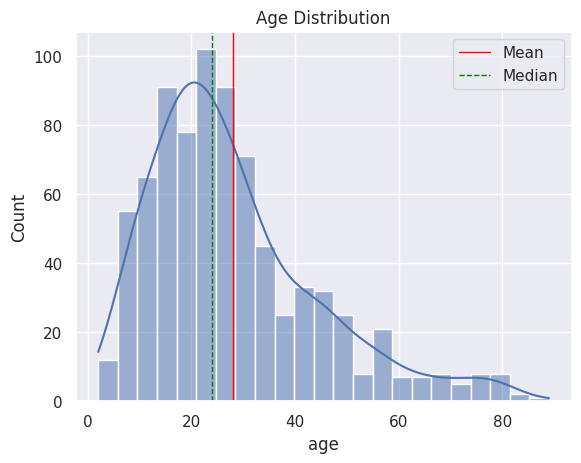

In [ ]:
# Histogram for age
sns.histplot(data['age'], kde=True, legend= True)
plt.title('Age Distribution')

# calculate mean and median
age_mean = data['age'].mean()
age_median = data['age'].median()

print("Mean: ",age_mean)
print("Median: ",age_median)

# add vertiacl lines for mean and median
plt.axvline(age_mean, color='red', linewidth=1, label='Mean')
plt.axvline(age_median, color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()

plt.show()

Mean:  8.537303106501248
Median:  9.605299308


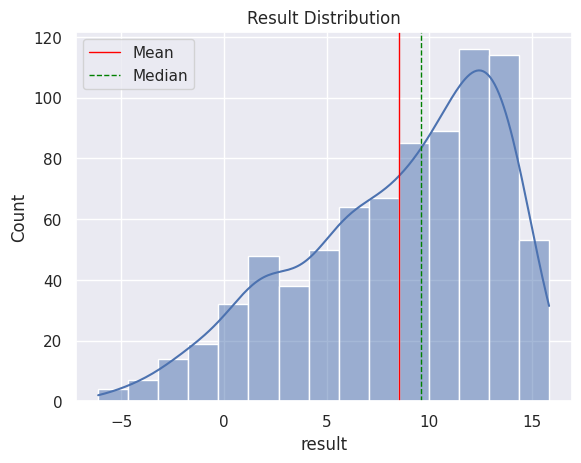

In [ ]:
# Histogram for "result"
sns.histplot(data['result'], kde=True, legend= True)
plt.title('Result Distribution')

# calculate mean and median
result_mean = data['result'].mean()
result_median = data['result'].median()

print("Mean: ",result_mean)
print("Median: ",result_median)

# add vertiacl lines for mean and median
plt.axvline(result_mean, color='red', linewidth=1, label='Mean')
plt.axvline(result_median, color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()

plt.show()

Box Plots for identifying outliers in the numerical columns

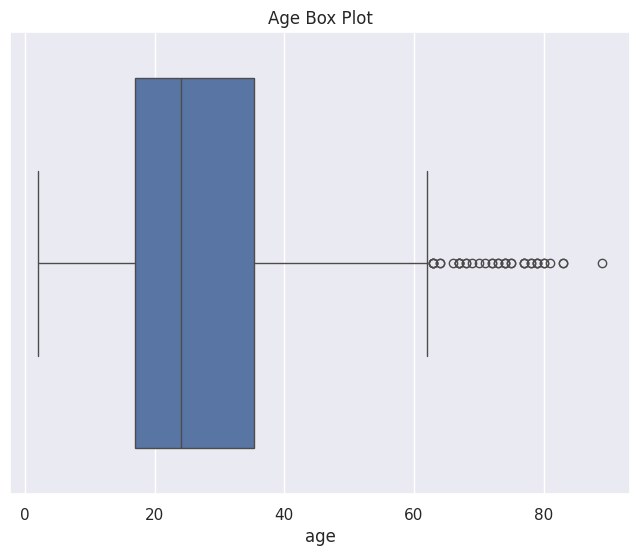

In [ ]:
# box plot for age
plt.figure(figsize=(8,6))
sns.boxplot(x=data['age'])
plt.title('Age Box Plot')
plt.show()

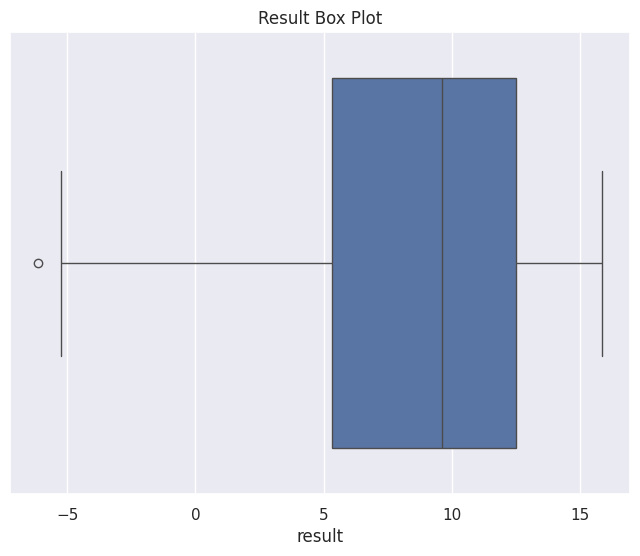

In [ ]:
# box plot for result
plt.figure(figsize=(8,6))
sns.boxplot(x=data['result'])
plt.title('Result Box Plot')
plt.show()


Count outliers by IQR

In [ ]:
# count outliers for age column
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

age_outliers = data[(data['age'] < lower_bound) | (data['age'] > upper_bound)]

In [ ]:
len(age_outliers)

39

In [ ]:
# count outliers for result column
Q1 = data['result'].quantile(0.25)
Q3 = data['result'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

result_outliers = data[(data['result'] < lower_bound) | (data['result'] > upper_bound)]

In [ ]:
len(result_outliers)

1

Univariate analysis of Categorical columns

In [ ]:
data.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'jaundice', 'austim', 'result', 'relation', 'Class/ASD'],
      dtype='object')

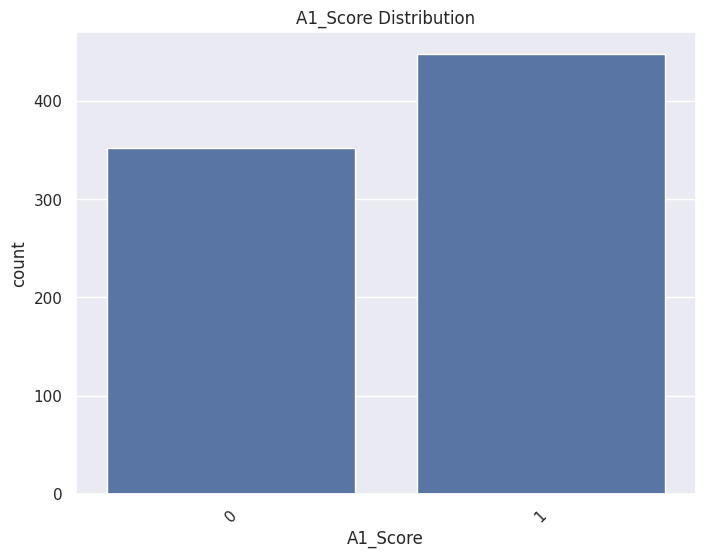

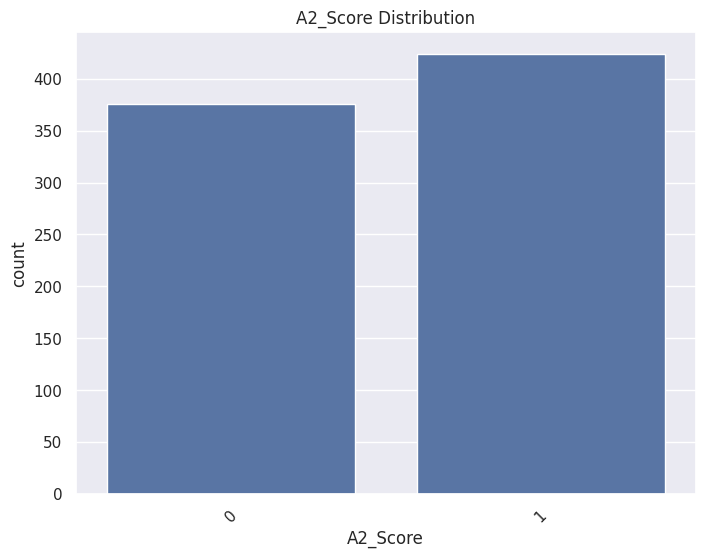

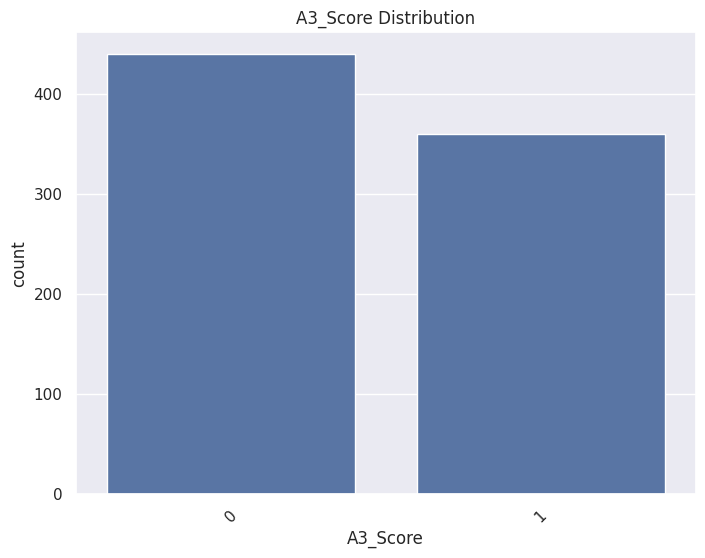

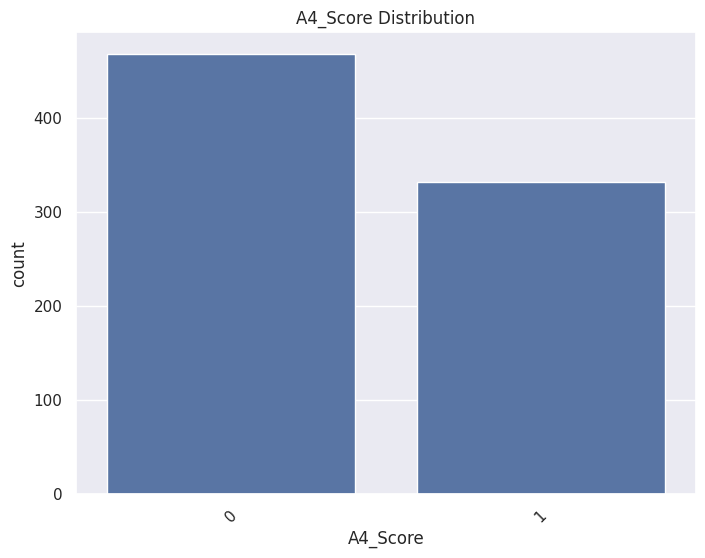

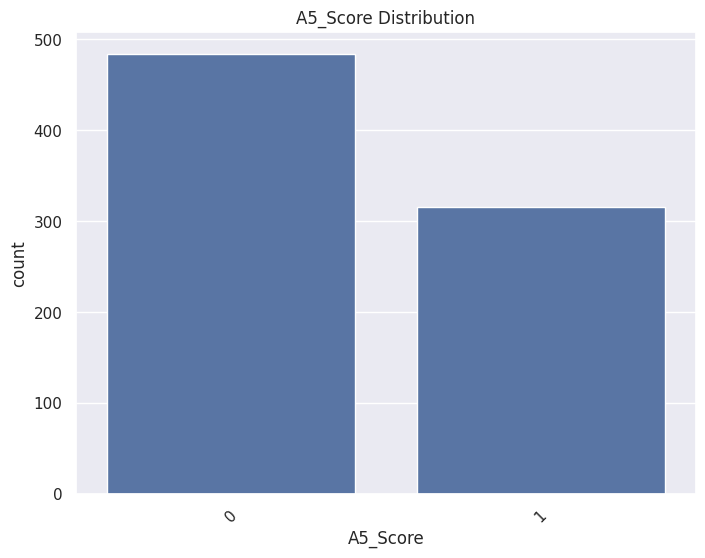

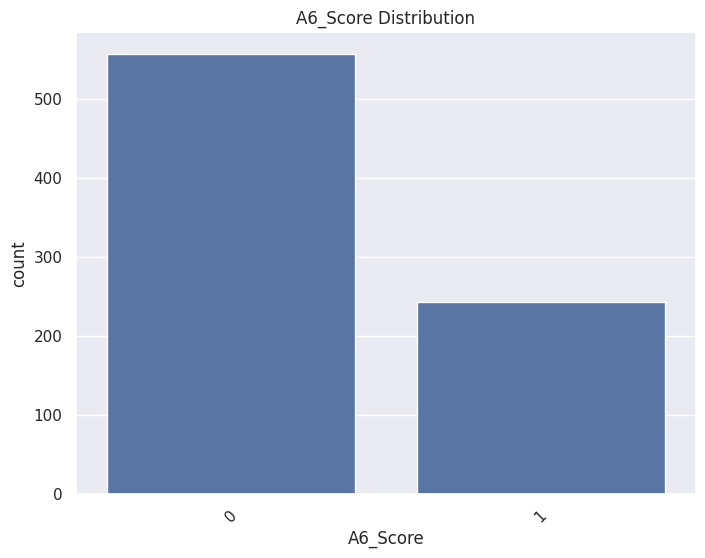

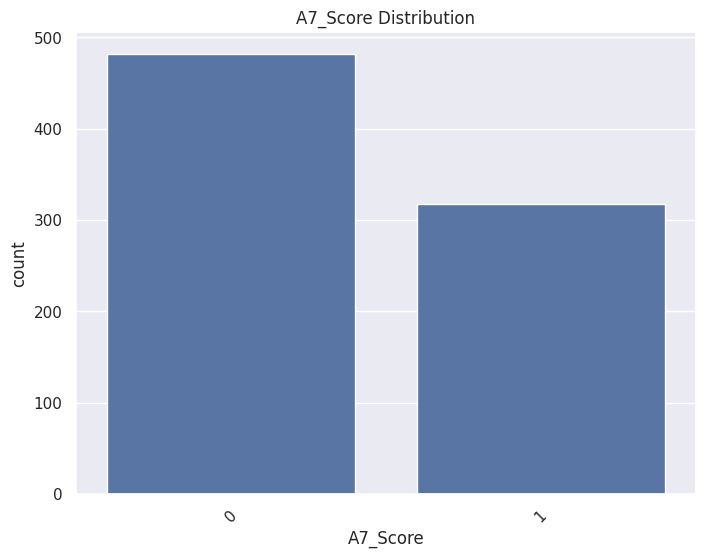

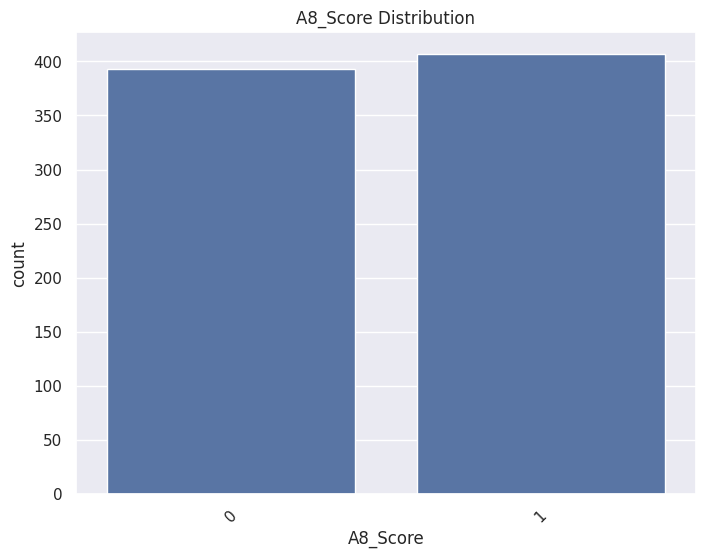

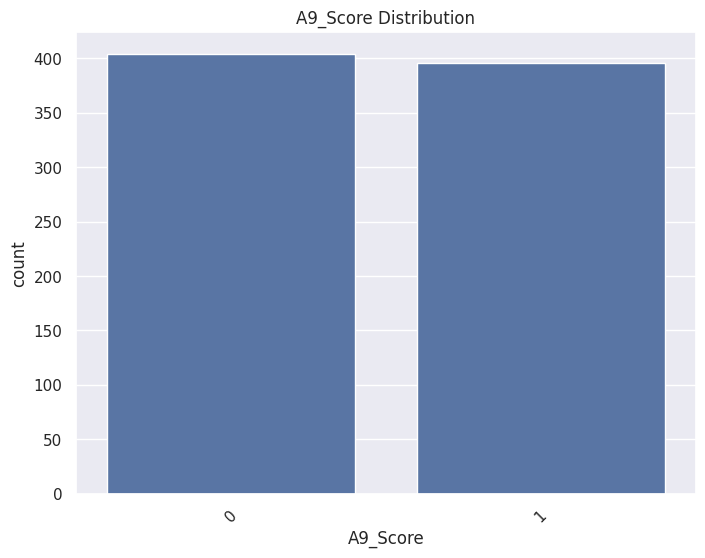

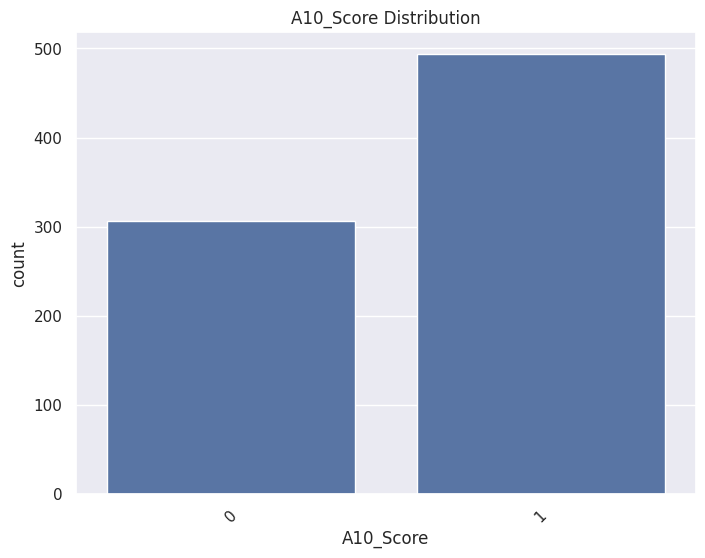

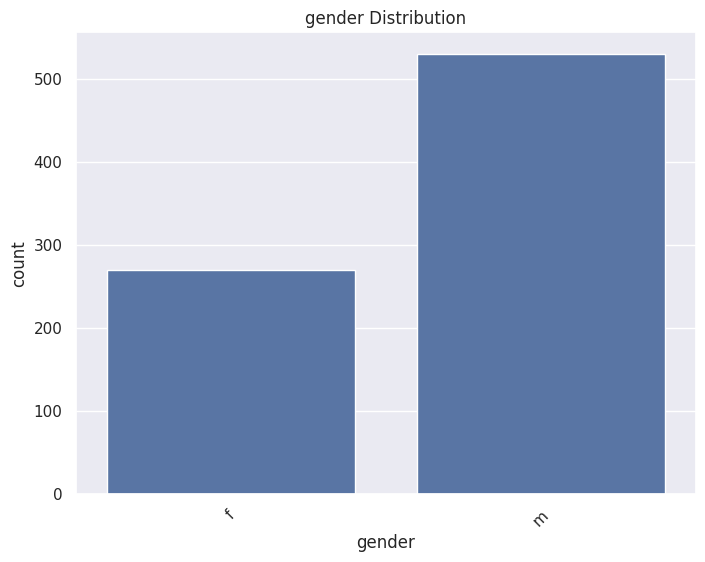

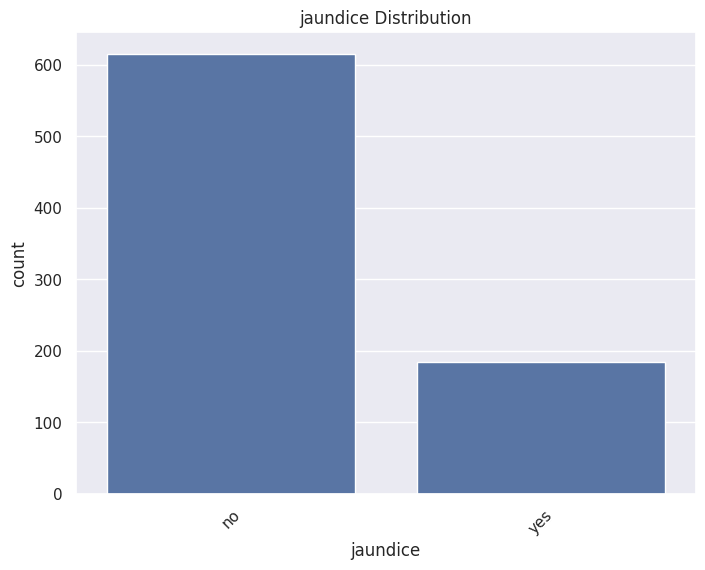

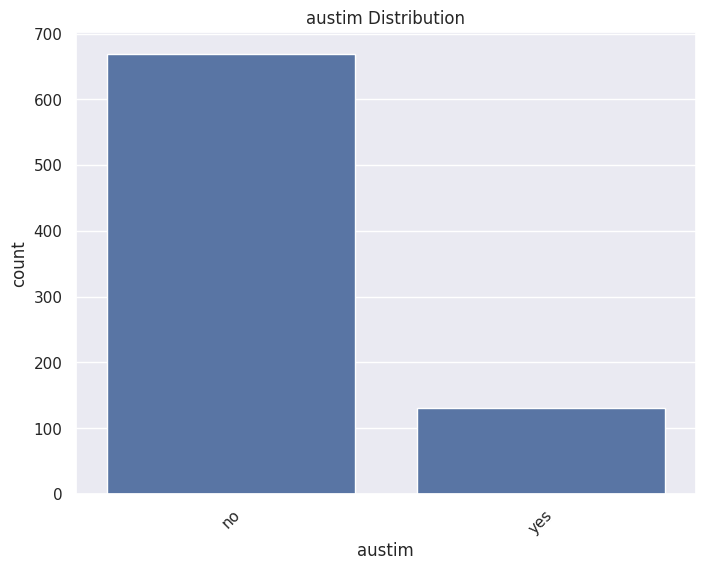

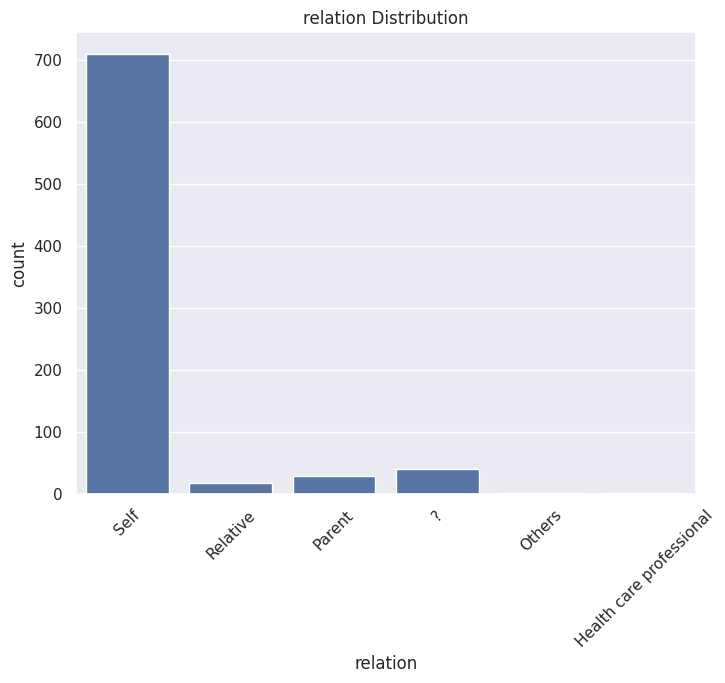

In [ ]:
categorical_cols = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender', 'jaundice', 'austim',
       'relation']
for col in categorical_cols:
  plt.figure(figsize=(8,6))
  sns.countplot(x=data[col])
  plt.title(f'{col} Distribution')
  plt.xticks(rotation=45)
  plt.show()

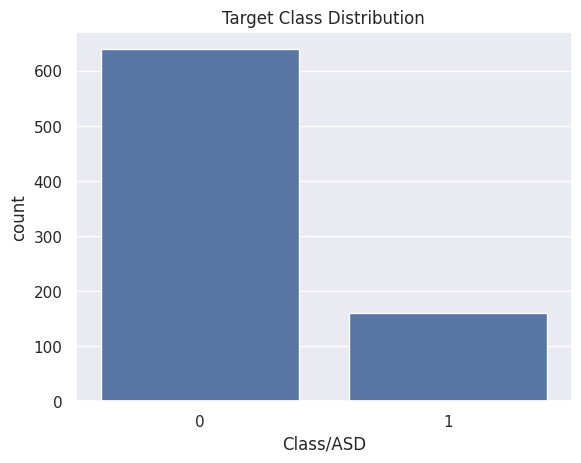

In [ ]:
# count plot for target column
sns.countplot(x=data['Class/ASD'])
plt.title('Target Class Distribution')
plt.show()

In [ ]:
data['Class/ASD'].value_counts()

,count
Class/ASD,
0,639
1,161


handle missing values in relation column

In [ ]:
data['relation'] = data['relation'].replace({'?': 'Others', 'Relative': 'Others', 'Health care professional': 'Others', 'Parent': 'Others'})

In [ ]:
data['relation'].unique()

array(['Self', 'Others'], dtype=object)

**Label Encoding**

In [ ]:
# identify columns with object data type
object_columns = data.select_dtypes(include=['object']).columns
# initialize a dictionary to store the encodes
encoders ={}
# apply label encoding and store the encoders
for col in object_columns:
  label_encoder = LabelEncoder()
  data[col] = label_encoder.fit_transform(data[col])
  encoders[col] = label_encoder # saving the encoder for this columns

# save the encoders as a pickle file
with open('encoders.pkl', 'wb') as f:
  pickle.dump(encoders, f)

In [ ]:
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,0,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,0,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7,1,0,1,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23,0,0,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43,1,0,0,-4.777286,1,0


In [ ]:
for col in data.columns:
  if col != 'result':
    print(col, data[col].unique())
    print('-'*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
age [38 47  7 23 43 31 28 26 48 24 21  9 56 29 14 72 25 15 41 54 12 30 74 67
 22 11 44 35 17 18  6 46 42 51 13 16 37 19 32 49 36 75 79 34 55 57 27 61
 10 58  8 33 20 40  3 45 69 64 39 78 60 63  2 77 53  5 68 62 81 50 73 80
  4 70 83 89 52 71 66]
--------------------------------------------------
gender [0 1]
-----------------------------

Bivariate analysis

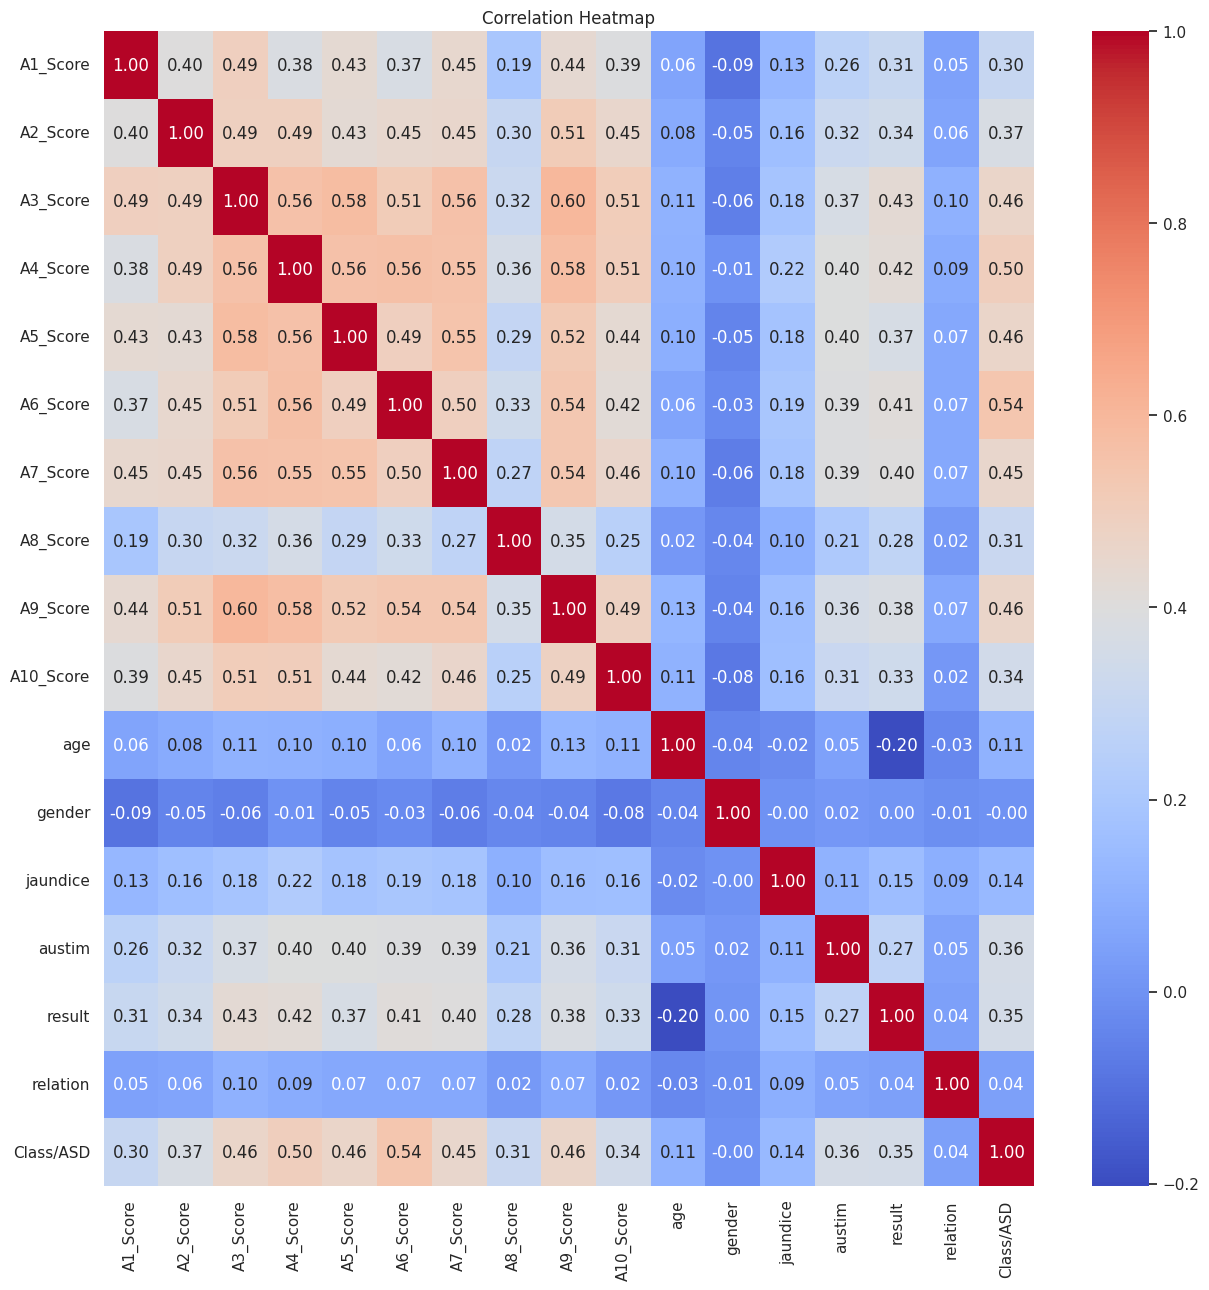

In [ ]:
# correlation
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Insights from EDA:**


*   there is a few outliers in numerical columns (age, result)
*   there is a class imbalance in the target column
*   there is a class imbalance in the categorical features
*   we donnot have positive correlated column
*   performed label encoding and save the encoder






# **Data prepocessing**

handling teh outliers

In [ ]:
# funtion to replace the outliers with median
def replace_outliers_with_median(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  median = data[column].median()
  # replace outliers with median value
  data[column] = data[column].apply(lambda x: median if (x < lower_bound) or (x > upper_bound) else x)
  return data

In [ ]:
data = replace_outliers_with_median(data, "age")
data = replace_outliers_with_median(data, "result")

In [ ]:
X = data.drop(columns=['Class/ASD'])
y = data['Class/ASD']

Spliting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

,count
Class/ASD,
0,515
1,125


In [ ]:
y_test.value_counts()

,count
Class/ASD,
0,124
1,36


**Synthetic Minority Oversampling Technique (SMOTE)**

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()

,count
Class/ASD,
1,515
0,515


# **Model training**

In [ ]:
# list of classifiers
models = {"Decision Tree": DecisionTreeClassifier(random_state=42),
          "Random Forest": RandomForestClassifier(random_state=42),
          "XGBoost": XGBClassifier(random_state=42)
          }

In [ ]:
# dict to store the cross validation results
cv_scores = {}
# perform 5_fold cross validation for each model
for model_name, model in models.items():
  print(f"training {model_name} with default parameters")
  score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
  cv_scores[model_name] = score
  print(f"{model_name} accuracy: {round(score.mean(),2)}")
  print("-"*50)

training Decision Tree with default parameters
Decision Tree accuracy: 0.87
--------------------------------------------------
training Random Forest with default parameters
Random Forest accuracy: 0.92
--------------------------------------------------
training XGBoost with default parameters
XGBoost accuracy: 0.91
--------------------------------------------------


# **Model selection and Hyperparameter tuning**

In [ ]:
# initialize models
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgboost_classifier = XGBClassifier(random_state=42)


In [ ]:
# hyperparameter grids for RandomizedSearchCv
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_random_forest = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_XGBoost = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [ ]:
# Hyperparameter tuning for 3 trees based models
# The below steps can be automatic by using a for loop or by using a pipeline
# Perform RandomizedSearchCV
random_search_decison_tree = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_decision_tree, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_random_forest = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_random_forest, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_XGBoost = RandomizedSearchCV(estimator=xgboost_classifier, param_distributions=param_grid_XGBoost, n_iter=20, cv=5, scoring='accuracy', random_state=42)


In [ ]:
# fit the models
random_search_decison_tree.fit(X_train_resampled, y_train_resampled)
random_search_random_forest.fit(X_train_resampled, y_train_resampled)
random_search_XGBoost.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
# get the model with best score
best_model = None
best_score = 0

if random_search_decison_tree.best_score_ > best_score:
  best_model = random_search_decison_tree
  best_score = random_search_decison_tree.best_score_

if random_search_random_forest.best_score_ > best_score:
  best_model = random_search_random_forest
  best_score = random_search_random_forest.best_score_

if random_search_XGBoost.best_score_ > best_score:
  best_model = random_search_XGBoost
  best_score = random_search_XGBoost.best_score_

In [ ]:
print("Best Model: ",best_model.estimator)
print("Best Cross-Validation Accuracy: ",round(best_score,2))

Best Model:  RandomForestClassifier(random_state=42)
Best Cross-Validation Accuracy:  0.93


In [ ]:
# save the best model
with open('best_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)

In [ ]:
# evaluate on test data
y_pred = best_model.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, y_pred))
print("Classification Report:\n ",classification_report(y_test, y_pred))
print("Confussion Matrix:\n",confusion_matrix(y_test, y_pred))



Accuracy Score:  0.8
Classification Report:
                precision    recall  f1-score   support

           0       0.86      0.89      0.87       124
           1       0.56      0.50      0.53        36

    accuracy                           0.80       160
   macro avg       0.71      0.69      0.70       160
weighted avg       0.79      0.80      0.80       160

Confussion Matrix:
 [[110  14]
 [ 18  18]]


In [ ]:
X_test.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,austim,result,relation
696,1,1,0,0,0,0,0,1,1,0,13.0,0,0,0,13.332323,1
667,0,0,0,0,0,0,0,0,0,0,25.0,1,0,0,6.479508,0
63,0,0,0,0,0,0,0,0,0,0,14.0,1,0,0,14.772424,1
533,0,0,0,0,0,0,0,1,0,0,21.0,1,0,0,9.656317,1
66,0,0,0,0,0,0,0,1,1,0,16.0,0,0,0,1.388938,1


In [ ]:
y_test.head()

,Class/ASD
696,0
667,0
63,0
533,0
66,0
